In [1]:
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from ase import *
from ase.io import read
from gpaw import *

from gpaw.utilities.dos import LCAODOS, RestartLCAODOS


from gpaw.lcao.pwf2 import LCAOwrap
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from qtpyt.basis import Basis
from qtpyt.lo.tools import rotate_matrix, subdiagonalize_atoms, lowdin_rotation
from ase.io import read
from qtpyt.basis import Basis

import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt
import itertools

[anooja-ThinkPad-X1-Carbon-Gen-11:24927] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


### Helper functions

In [2]:
cmap_name = 'custom_white_red'
colors = [(1, 1, 1), (166/255, 4/255, 4/255)]
n_bins = 100
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
norm = LogNorm(vmin=0.1, vmax=10)

In [3]:
def get_species_indices(atoms,species):
    indices = []
    for element in species:
        element_indices = atoms.symbols.search(element)
        indices.extend(element_indices)
    return sorted(indices)

def plot_atomic_positions_by_species(atoms, element_colors):
    fig, ax = plt.subplots(figsize=(5, 10))
    positions = atoms.positions
    x = positions[:, 0]
    y = positions[:, 1]

    colors = [element_colors[atom.symbol] for atom in atoms]

    ax.scatter(x, y, color=colors, s=300)

    for i, (xi, yi) in enumerate(zip(x, y)):
        ax.text(xi, yi, str(i), color='black', fontsize=9, ha='center', va='center')


    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    ax.set_title('Atomic Positions by Species')

    plt.show()

def create_active_hamiltonian(H, S,  index_active_region):
    # Create a list of indices to retain
    indices_to_keep = sorted(list(index_active_region))

    # Create the H_active matrix by extracting the relevant rows and columns
    H_active = H[np.ix_(indices_to_keep, indices_to_keep)]
    S_active = S[np.ix_(indices_to_keep, indices_to_keep)]

    return H_active, S_active


In [4]:
def calculate_homo_lumo(H, S, homo_index, lumo_index):
    """Calculate HOMO, LUMO, and the HOMO-LUMO gap."""
    eigenvalues, _ = eigh(H, S)
    homo_energy = eigenvalues[homo_index]
    lumo_energy = eigenvalues[lumo_index]
    homo_lumo_gap = lumo_energy - homo_energy

    return homo_energy, lumo_energy, homo_lumo_gap


def plot_orbital_energies(H, S, fermi_level=0, n_valence=1, n_conduction=3, title='Orbital Energies'):
    """Plot eigenvalues around the Fermi level."""
    eigenvalues, _ = eigh(H, S)
    fermi_index = np.argmin(np.abs(eigenvalues - fermi_level))
    start_index = max(fermi_index - n_valence, 0)
    end_index = min(fermi_index + n_conduction + 1, len(eigenvalues))
    selected_indices = np.arange(start_index, end_index)

    plt.figure(figsize=(8, 6))
    x_min, x_max = -0.5, 0.5

    for idx in selected_indices:
        energy = eigenvalues[idx]
        plt.hlines(energy, x_min, x_max, colors='blue', linestyles='--')
    plt.axhline(0, color='red', linestyle='--', label='Fermi Level')

    plt.title(title)
    plt.ylabel('Energy (eV)')
    plt.legend()
    plt.grid(True)
    plt.show()


def find_best_active_space(H, S, basis_subdiag_region, index_subdiag_region, target_gap, lowdin=True):
    """Find the active space that provides the closest HOMO-LUMO gap to the target."""
    num_spherical_harmonics_C = 13
    best_active_dict = {}
    best_gap_diff = float('inf')

    for num_C_orbitals in range(1, num_spherical_harmonics_C + 1):
        for combination in itertools.combinations(range(num_spherical_harmonics_C), num_C_orbitals):
            active = {'C': list(combination)}
            extract_active_region = basis_subdiag_region.extract().take(active)
            index_active_region = index_subdiag_region[extract_active_region]

            if lowdin:
                Ulow = lowdin_rotation(H, S, index_active_region)
                H = rotate_matrix(H, Ulow)
                S = rotate_matrix(S, Ulow)

            H_active, S_active = H[index_active_region], S[index_active_region]
            eigenvalues, _ = eigh(H_active, S_active)

            lumo_index = int(len(eigenvalues) / 2)
            homo_index = lumo_index - 1
            homo_lumo_gap = eigenvalues[lumo_index] - eigenvalues[homo_index]
            gap_diff = abs(homo_lumo_gap - target_gap)

            if gap_diff < best_gap_diff:
                best_gap_diff = gap_diff
                best_active_dict = active
                best_homo_lumo_gap = homo_lumo_gap

    print("\nBest active space found:")
    print(f"Active space: {best_active_dict}")
    print(f"Closest HOMO-LUMO gap: {best_homo_lumo_gap:.6f} eV")
    print(f"Difference from target gap: {best_gap_diff:.6f} eV")

    return best_active_dict, best_homo_lumo_gap, best_gap_diff


def plot_hamiltonian_overlap(H, S, cmap, norm, title_H="H Matrix", title_S="S Matrix"):
    """
    Plot the Hamiltonian and Overlap matrices with a shared colorbar and customized color mapping.

    Parameters:
    - H: np.ndarray, Hamiltonian matrix to visualize.
    - S: np.ndarray, Overlap matrix to visualize.
    - cmap: Colormap, the colormap for the plot.
    - norm: Normalization, the normalization for color mapping.
    - title_H: str, Title for the Hamiltonian plot.
    - title_S: str, Title for the Overlap plot.

    Returns:
    - None, displays the plots.
    """
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot H matrix
    cax1 = axs[0].imshow(np.abs(H), interpolation='nearest', cmap=cmap, norm=norm)
    axs[0].set_title(title_H)

    # Plot S matrix
    cax2 = axs[1].imshow(np.abs(S), interpolation='nearest', cmap=cmap, norm=norm)
    axs[1].set_title(title_S)

    # Add a single colorbar shared by both subplots
    cbar = fig.colorbar(cax2, ax=axs, orientation='vertical', fraction=0.03, pad=0.04)
    cbar.set_label('Energy (eV)')

    # plt.tight_layout()
    plt.show()



def print_largest_non_diagonal_elements(S, n=3):
    """
    Prints the n largest non-diagonal absolute values from an overlap matrix.

    Parameters:
    - S: np.ndarray, the overlap matrix.
    - n: int, the number of largest non-diagonal elements to print.

    Returns:
    - None, prints the largest values and their indices.
    """
    # Ensure the input matrix is square
    assert S.shape[0] == S.shape[1], "The overlap matrix must be square."

    # Get absolute values and remove the diagonal by setting it to zero
    abs_S = np.abs(S)
    np.fill_diagonal(abs_S, 0)

    # Find the indices of the largest elements
    flat_indices = np.argsort(abs_S, axis=None)[-n:]
    row_indices, col_indices = np.unravel_index(flat_indices, S.shape)
    largest_values = abs_S[row_indices, col_indices]

    # Print the results
    print(f"The {n} largest non-diagonal elements in the overlap matrix are:")
    for i in range(n):
        print(f"Value: {largest_values[i]:.4f} at indices ({row_indices[i]}, {col_indices[i]})")


def plot_occupation_numbers(occupations, title="Occupation Numbers per Orbital"):
    """
    Plot occupation numbers per orbital as a bar chart.

    Parameters:
    - occupations: array-like, occupation numbers for each orbital.
    - title: str, title for the plot.

    Returns:
    - None, displays the bar plot of occupation numbers.
    """
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(occupations)), occupations, color='b', label='Occupation Number')

    plt.title(title)
    plt.xlabel("Orbital Index")
    plt.ylabel("Occupation Number")
    plt.ylim([-0.1, 2.1])  # Typical range for occupation numbers
    plt.grid(axis='y')
    plt.legend()
    plt.show()


## Visualize structure and how the atoms are ordered

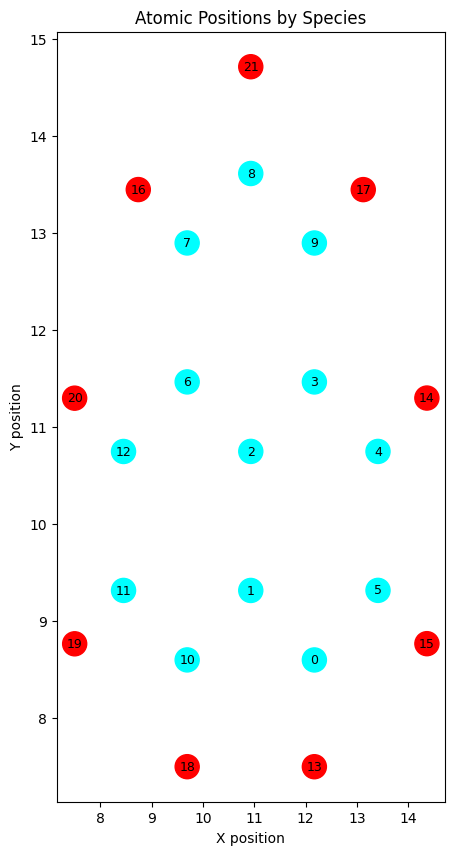

In [5]:
atoms = read('./struct.xyz')
element_colors = {'C':'cyan','H':'red'}

plot_atomic_positions_by_species(atoms, element_colors)

### Check DFT calculations

In [6]:
gpaw_file = 'output/gpaw/HubbardU0/struct.gpw'
calc = GPAW(gpaw_file, txt=None)
dos = RestartLCAODOS(calc)
pdos = LCAODOS(calc)
E_fermi = calc.get_fermi_level()
eigenvalues = calc.get_eigenvalues()
homo_energy, lumo_energy = calc.get_homo_lumo()
# Find the band index of HOMO and LUMO by matching with eigenvalues
homo_index = np.where(np.isclose(eigenvalues, homo_energy))[0][0]
lumo_index = np.where(np.isclose(eigenvalues, lumo_energy))[0][0]

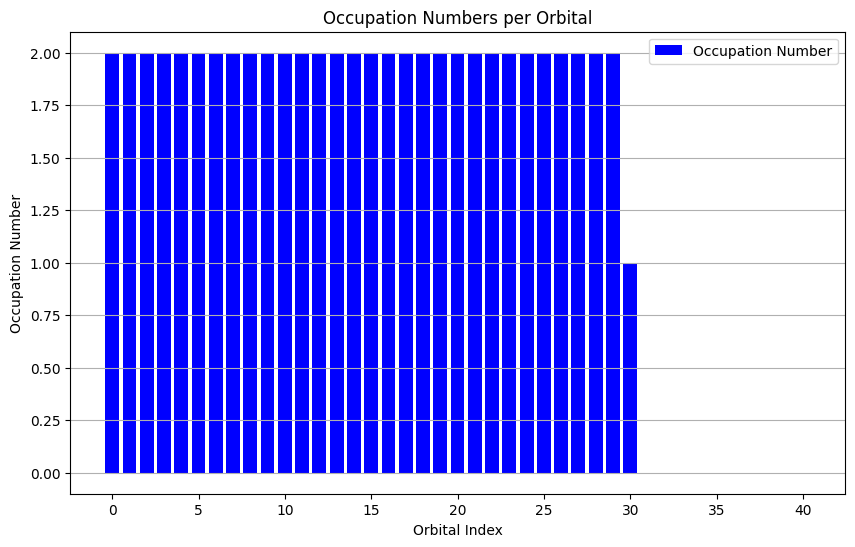

In [7]:
occ = calc.get_occupation_numbers()
plot_occupation_numbers(occ, title="Occupation Numbers per Orbital")

### Get Hamiltonian and Overlap matrices in the LCAO basis

In [8]:
# Since this is a molecule, I've performed a Gamma point calculation and the assumption is the H_gamma is equivalent to a real space Hamiltonian H_R.

lcao = LCAOwrap(calc)
H_lcao = lcao.get_hamiltonian()
S_lcao = lcao.get_overlap()

# Move Fermi to 0 eV

H_lcao -= E_fermi * S_lcao

Condition number: 3.3e+04


In [9]:
nao_a = np.array([setup.nao for setup in calc.wfs.setups])
print(nao_a)

[13 13 13 13 13 13 13 13 13 13 13 13 13  5  5  5  5  5  5  5  5  5]


In [10]:
atoms

Atoms(symbols='C13H9', pbc=False, cell=[21.86627466, 22.210973751710853, 15.0])

In [11]:
basis = Basis(atoms, nao_a)
basis

In [33]:
# Perform subdiagonalization

nao_a = np.array([setup.nao for setup in calc.wfs.setups])
basis = Basis(atoms, nao_a)

SUBDIAG_SPECIES = ("C", "H")
subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)

# Extract the basis for the subdiagonalized region and get their indices
basis_subdiag_region = basis[subdiag_indices]
index_subdiag_region = basis_subdiag_region.get_indices()

Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)

# Rotate matrices
H_subdiagonal = rotate_matrix(H_lcao, Usub)
S_subdiagonal = rotate_matrix(S_lcao, Usub)

# Define the active region within the subdiagonalized species (C 2 pz in this case)
active = {'C':[3]}
extract_active_region = basis_subdiag_region.extract().take(active)
index_active_region = index_subdiag_region[extract_active_region]


for idx in index_active_region:
    if Usub[idx-1,idx] < 0.: # change sign
        Usub[:,idx] *= -1

H_active, S_active = create_active_hamiltonian(H_subdiagonal, S_subdiagonal, index_active_region)

lowdin = True
if lowdin:
    Ulow = lowdin_rotation(H_subdiagonal, S_subdiagonal, index_active_region)

    H_subdiagonal_low = rotate_matrix(H_subdiagonal, Ulow)
    S_subdiagonal_low = rotate_matrix(S_subdiagonal, Ulow)

H_active_low, S_active_low = create_active_hamiltonian(H_subdiagonal_low, S_subdiagonal_low, index_active_region)

### Get Hamiltonian and Overlap matrices in the LO basis and Pick out only C 2pz orbitals 

I know a priori that, of the 13 orbitals of C, index '3' corresponds to C 2pz. This is based on visualizing the LOs cube files. If you are interested in, for example, the 1s orbitals, visualize the cube files for the orbitals and find which index produced a cube file that shows 1s behavior. The following calculation shows how to extract only the C 2pz contributions to the Hamiltonian

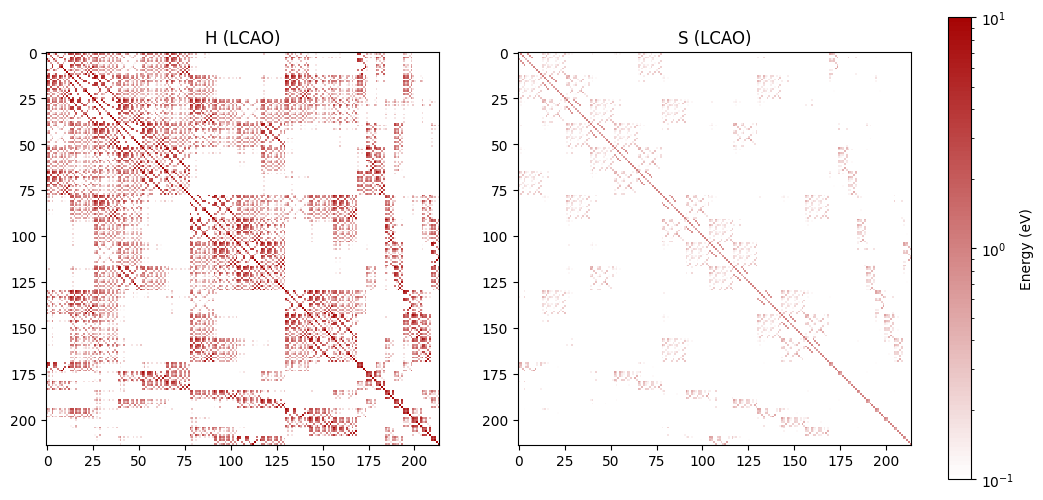

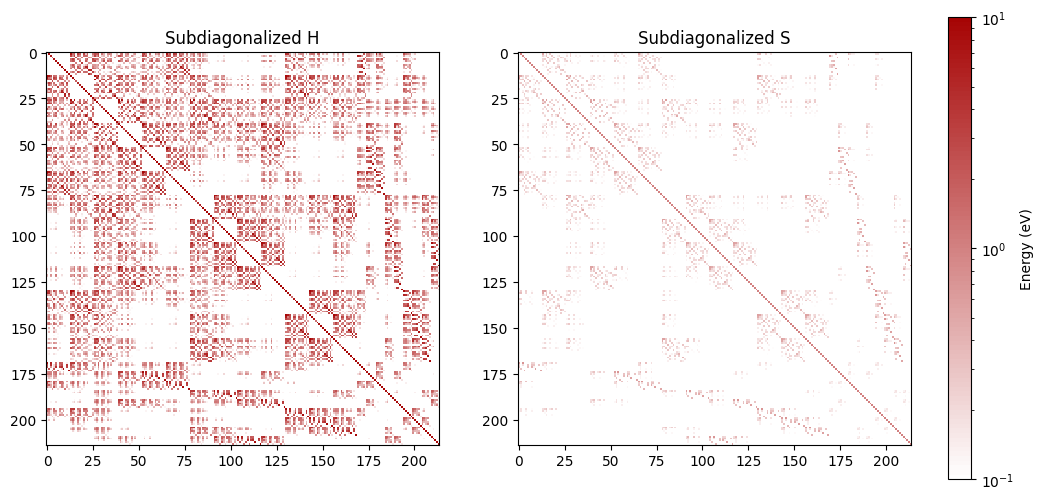

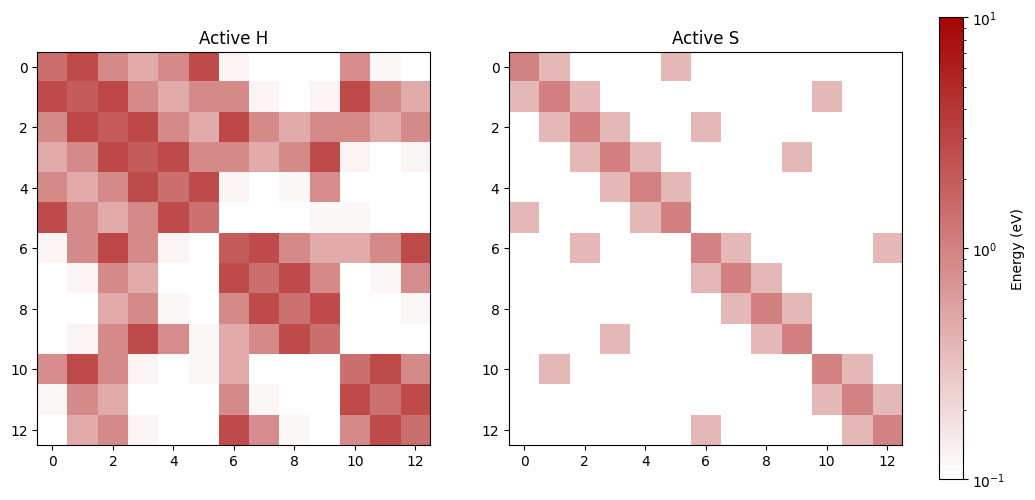

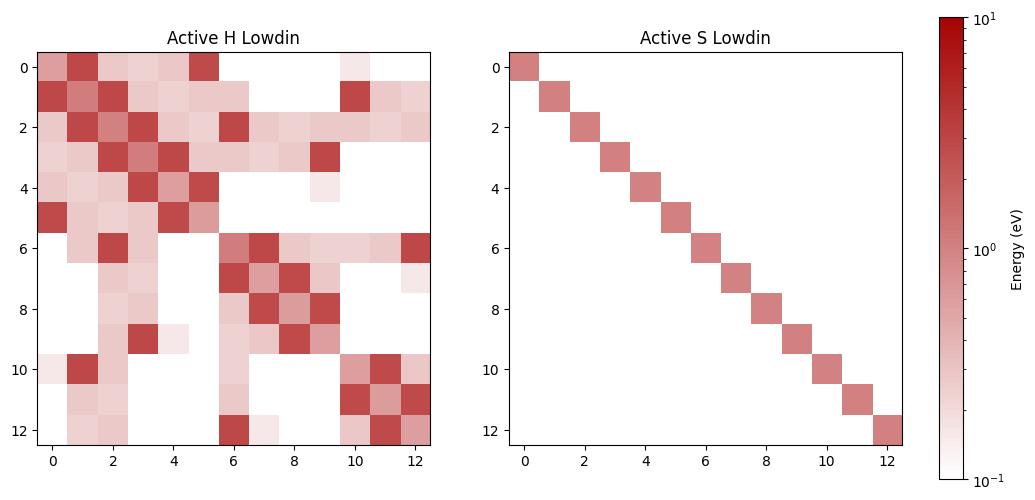

In [34]:
# Plot LCAO matrices
plot_hamiltonian_overlap(H_lcao, S_lcao, title_H="H (LCAO)", title_S="S (LCAO)", cmap=cmap, norm=norm)

# Plot subdiagonalized matrices
plot_hamiltonian_overlap(H_subdiagonal, S_subdiagonal, title_H="Subdiagonalized H", title_S="Subdiagonalized S", cmap=cmap, norm=norm)

plot_hamiltonian_overlap(H_active, S_active, title_H="Active H", title_S="Active S", cmap=cmap, norm=norm)

plot_hamiltonian_overlap(H_active_low, S_active_low, title_H="Active H Lowdin", title_S="Active S Lowdin", cmap=cmap, norm=norm)

In [37]:
print_largest_non_diagonal_elements(S_active, n=1)

The 1 largest non-diagonal elements in the overlap matrix are:
Value: 0.3717 at indices (2, 3)


HOMO energy: -2.403139756540461 eV
LUMO energy: 7.100944541067393e-07 eV
HOMO-LUMO gap: 2.4031404666349148 eV


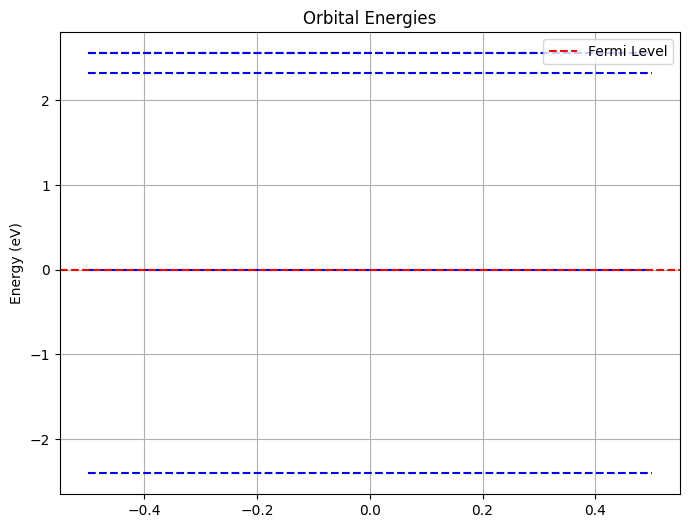

HOMO energy: -2.403139756540448 eV
LUMO energy: 7.100944628198515e-07 eV
HOMO-LUMO gap: 2.4031404666349108 eV


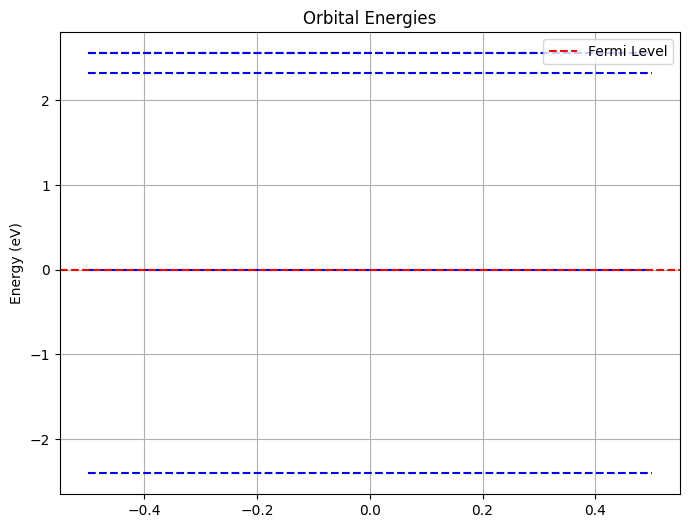

HOMO energy: -2.026923161721295 eV
LUMO energy: 0.23692509847589166 eV
HOMO-LUMO gap: 2.2638482601971868 eV


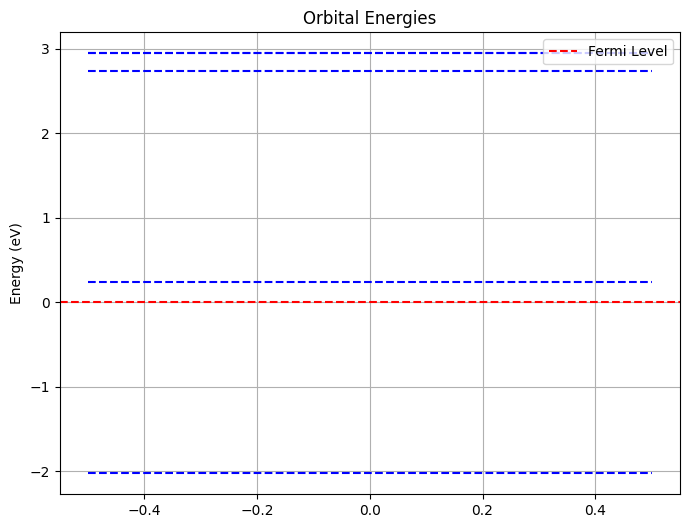

HOMO energy: -2.0269231617212946 eV
LUMO energy: 0.2369250984758926 eV
HOMO-LUMO gap: 2.263848260197187 eV


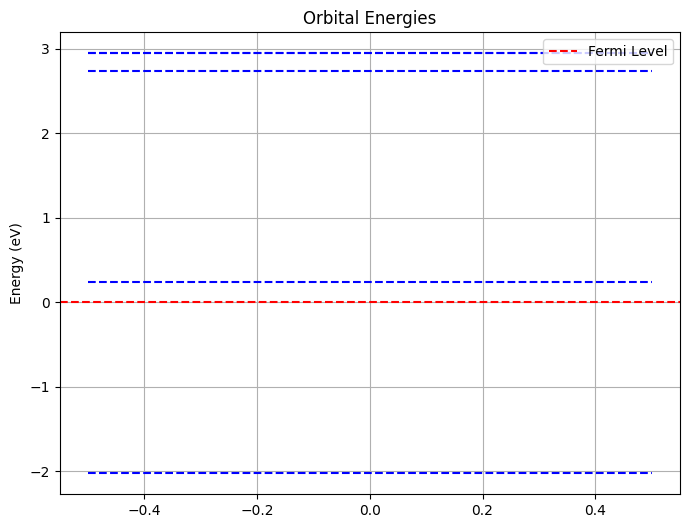

In [35]:
# Diagonalize the Hamiltonian and overlap matrices
eigenvalues, eigenvectors = eigh(H_lcao, S_lcao)
# Calculate HOMO and LUMO energies, and gap
homo_energy, lumo_energy, homo_lumo_gap = calculate_homo_lumo(H_lcao, S_lcao,homo_index,lumo_index)
print(f"HOMO energy: {homo_energy} eV")
print(f"LUMO energy: {lumo_energy} eV")
print(f"HOMO-LUMO gap: {homo_lumo_gap} eV")

# Plot orbital energies around the Fermi level
plot_orbital_energies(H=H_lcao, S=S_lcao, fermi_level=0, n_valence=1, n_conduction=3)


# Diagonalize the Hamiltonian and overlap matrices
eigenvalues, eigenvectors = eigh(H_subdiagonal, S_subdiagonal)

# Calculate HOMO and LUMO energies, and gap
homo_energy, lumo_energy, homo_lumo_gap = calculate_homo_lumo(H_subdiagonal,S_subdiagonal,homo_index,lumo_index)
print(f"HOMO energy: {homo_energy} eV")
print(f"LUMO energy: {lumo_energy} eV")
print(f"HOMO-LUMO gap: {homo_lumo_gap} eV")

# Plot orbital energies around the Fermi level
plot_orbital_energies(H=H_subdiagonal, S=S_subdiagonal, fermi_level=0, n_valence=1, n_conduction=3)

# Diagonalize the Hermitian Hamiltonian using eigh (eigenvalues are automatically sorted)
eigenvalues, eigenvectors = eigh(H_active,S_active)

# Since the H_active has dimensions 26 X 26 and there are 2 electrons per state, 13 states are occupied and 13 are unoccupied.
lumo_index_active = int(np.shape(H_active)[0]/2)
homo_index_active = lumo_index_active - 1

# Calculate HOMO and LUMO energies, and gap
homo_energy, lumo_energy, homo_lumo_gap = calculate_homo_lumo(H_active,S_active,homo_index_active,lumo_index_active)
print(f"HOMO energy: {homo_energy} eV")
print(f"LUMO energy: {lumo_energy} eV")
print(f"HOMO-LUMO gap: {homo_lumo_gap} eV")

# Plot orbital energies around the Fermi level
plot_orbital_energies(H=H_active, S=S_active, fermi_level=0, n_valence=1, n_conduction=3)

# Diagonalize the Hermitian Hamiltonian using eigh (eigenvalues are automatically sorted)
eigenvalues, eigenvectors = eigh(H_active_low,S_active_low)

# Calculate HOMO and LUMO energies, and gap
homo_energy, lumo_energy, homo_lumo_gap = calculate_homo_lumo(H_active_low,S_active_low,homo_index_active,lumo_index_active)
print(f"HOMO energy: {homo_energy} eV")
print(f"LUMO energy: {lumo_energy} eV")
print(f"HOMO-LUMO gap: {homo_lumo_gap} eV")

# Plot orbital energies around the Fermi level
plot_orbital_energies(H=H_active_low, S=S_active_low, fermi_level=0, n_valence=1, n_conduction=3)

In [21]:
import itertools
import numpy as np
from scipy.linalg import eigh

num_spherical_harmonics_C = 13
num_spherical_harmonics_H = 5
target_gap = dft_gap  # Define your target gap

# Placeholder for the best active region and gap difference
best_active_dict = {}
best_gap_diff = float('inf')

# Iterate over all possible combinations of orbitals for C
for num_C_orbitals in range(1, num_spherical_harmonics_C + 1):
    for combination in itertools.combinations(range(num_spherical_harmonics_C), num_C_orbitals):
        # Define the active space dictionary for this iteration
        active = {'C': list(combination)}

        # Extract the active region and index it
        extract_active_region = basis_subdiag_region.extract().take(active)
        index_active_region = index_subdiag_region[extract_active_region]

        # Apply Lowdin rotation if required
        if lowdin:
            Ulow = lowdin_rotation(H_subdiagonal, S_subdiagonal, index_active_region)
            H_subdiagonal = rotate_matrix(H_subdiagonal, Ulow)
            S_subdiagonal = rotate_matrix(S_subdiagonal, Ulow)

        # Create the active Hamiltonian and overlap matrices
        H_active, S_active = create_active_hamiltonian(H_subdiagonal, S_subdiagonal, index_active_region)

        # Diagonalize the Hamiltonian
        eigenvalues, eigenvectors = eigh(H_active, S_active)

        # Calculate the HOMO and LUMO energies
        lumo_index_active = int(np.shape(H_active)[0] / 2)
        homo_index_active = lumo_index_active - 1

        homo_energy = eigenvalues[homo_index_active]
        lumo_energy = eigenvalues[lumo_index_active]

        # Calculate the HOMO-LUMO gap
        homo_lumo_gap = lumo_energy - homo_energy

        # Check if this gap is the closest to the target gap
        gap_diff = abs(homo_lumo_gap - target_gap)
        if gap_diff < best_gap_diff:
            best_gap_diff = gap_diff
            best_active_dict = active
            best_homo_lumo_gap = homo_lumo_gap

print("\nBest active space found:")
print(f"Active space: {best_active_dict}")
print(f"Closest HOMO-LUMO gap: {best_homo_lumo_gap:.6f} eV")
print(f"Difference from target gap: {best_gap_diff:.6f} eV")



Best active space found:
Active space: {'C': [0, 4, 6, 8, 9, 10, 12]}
Closest HOMO-LUMO gap: 2.406131 eV
Difference from target gap: 0.002991 eV


In [ ]:
import itertools
import numpy as np
from scipy.linalg import eigh

num_spherical_harmonics_H = 5
target_gap = dft_gap  # Define your target gap

# Placeholder for the best active region and gap difference
best_active_dict = {}
best_gap_diff = float('inf')

# Fix the active space for C
active_C = list(range(13))
active_H = list(range(5))

# Iterate over all possible combinations of orbitals for H
for num_H_orbitals in range(1, num_spherical_harmonics_H + 1):
    for combination_H in itertools.combinations(range(num_spherical_harmonics_H), num_H_orbitals):

        # Define the active space dictionary with fixed 'C': [3]
        active = {'C': active_C, 'H':active_H}#list(combination_H)}

        # Extract the active region and index it
        extract_active_region = basis_subdiag_region.extract().take(active)
        index_active_region = index_subdiag_region[extract_active_region]

        # Apply Lowdin rotation if required
        if lowdin:
            Ulow = lowdin_rotation(H_subdiagonal, S_subdiagonal, index_active_region)
            H_subdiagonal = rotate_matrix(H_subdiagonal, Ulow)
            S_subdiagonal = rotate_matrix(S_subdiagonal, Ulow)

        # Create the active Hamiltonian and overlap matrices
        H_active, S_active = create_active_hamiltonian(H_subdiagonal, S_subdiagonal, index_active_region)

        # Diagonalize the Hamiltonian
        eigenvalues, eigenvectors = eigh(H_active, S_active)

        # Calculate the HOMO and LUMO energies
        lumo_index_active = int(np.shape(H_active)[0] / 2)
        homo_index_active = lumo_index_active - 1

        homo_energy = eigenvalues[homo_index_active]
        lumo_energy = eigenvalues[lumo_index_active]

        # Calculate the HOMO-LUMO gap
        homo_lumo_gap = lumo_energy - homo_energy

        # Check if this gap is the closest to the target gap
        gap_diff = abs(homo_lumo_gap - target_gap)
        if gap_diff < best_gap_diff:
            best_gap_diff = gap_diff
            best_active_dict = active
            best_homo_lumo_gap = homo_lumo_gap

print("\nBest active space found:")
print(f"Active space: {best_active_dict}")
print(f"Closest HOMO-LUMO gap: {best_homo_lumo_gap:.6f} eV")
print(f"Difference from target gap: {best_gap_diff:.6f} eV")



Best active space found:
Active space: {'C': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'H': [0, 1, 2, 3, 4]}
Closest HOMO-LUMO gap: 0.130220 eV
Difference from target gap: 2.272920 eV
